In [1]:
import os
import sys
sys.path.append('../')

In [2]:
import cv2
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import OrderedDict
from model.retinanet import get_model
from utils import soft_nms

In [3]:
from config import get_args
from model.utils import BBoxTransform, ClipBoxes, nms_with_class, nms_without_class

cfg = get_args()
color_map = [(np.random.rand(), np.random.rand(), np.random.rand()) for _ in range(cfg.num_classes)]

In [4]:
model_path = "../checkpoints/coco/epoch_45_loss_0.61501.pth"
retinanet = get_model(num_classes=80, pretrained=False)
state_dict = torch.load(model_path)

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]   # remove `module.`
    new_state_dict[name] = v

retinanet.load_state_dict(new_state_dict)
retinanet = retinanet.cuda()
retinanet.eval()

RetinaNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

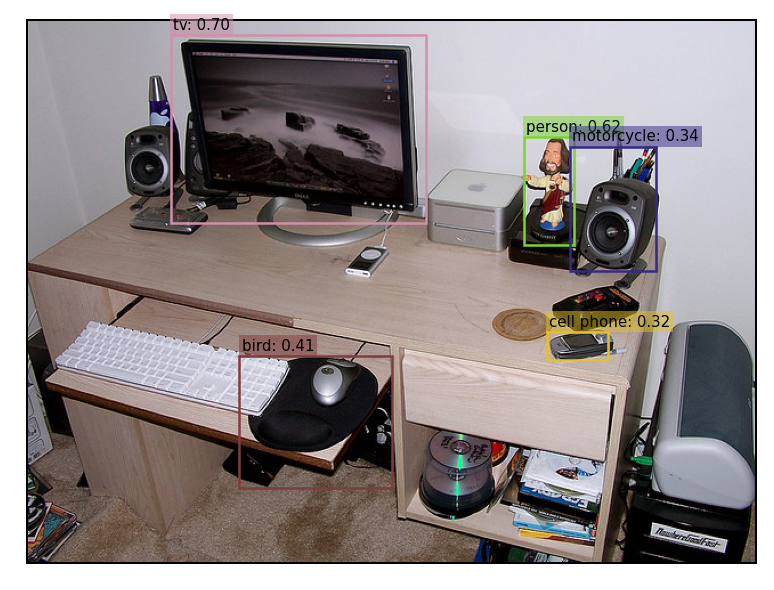

In [6]:
img_root = '/home/workspace/chencheng/Learning/ObjectDetection/Datasets/CoCodataset/train2017/'
img_lists = os.listdir(img_root)
plt.figure(dpi=180)
for i, img_path in enumerate(random.sample(img_lists, 1)):
    img_path = os.path.join(img_root, img_path)
    # img_path = '/home/workspace/chencheng/Learning/ObjectDetection/Datasets/CoCodataset/train2017/000000322763.jpg'
    img = cv2.imread(img_path)[..., ::-1]
    # img = cv2.resize(img, (640, 480))
    # plt.imshow(img)

    mean=(0.485, 0.456, 0.406)
    std=(0.229, 0.224, 0.225)
    normalized_imgs = (img / 255 - mean) / std 

    resize_wh = (1024, 768)
    ori_h, ori_w = normalized_imgs.shape[:2]
    scale = resize_wh[1] / ori_h
    if scale * ori_w > resize_wh[0]:
        scale = resize_wh[0] / ori_w
    new_h, new_w = int(scale * ori_h), int(scale * ori_w)
    img_resized = cv2.resize(normalized_imgs, (new_w, new_h))

    img_paded = np.zeros([resize_wh[1], resize_wh[0], 3])
    img_paded[:new_h, :new_w, :] = img_resized

    img_input = torch.from_numpy(img_paded).permute(2, 0, 1).unsqueeze(dim=0).float()
        
    if torch.cuda.is_available():
        img_input = img_input.cuda()
    features, regression, classification, anchors = retinanet(img_input)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    trans_anchors = regressBoxes(anchors, regression)
    transformed_anchors = clipBoxes(trans_anchors, img_input)

    scores, classes = torch.max(classification, dim=2)  # 计算anchor的最高得分和对应的类别
    over_score_thresh_mask = (scores > 0.3)
    if over_score_thresh_mask.sum() < 1:
        continue
    
    scores_over_thresh = scores[over_score_thresh_mask]
    classes_over_thresh = classes[over_score_thresh_mask]
    anchors_over_thresh = transformed_anchors[over_score_thresh_mask, ...]
    
    # anchors_nms_idx = nms_with_class(transformed_anchors_per, scores_per[:, 0],classes_, iou_threshold=0.2)
    anchors_nms_idx = nms_without_class(anchors_over_thresh, scores_over_thresh, iou_threshold=0.2)
    # anchors_nms_idx = soft_nms(anchors_over_thresh, scores_over_thresh, thresh=0.25)
    
    after_nms_anchors = anchors_over_thresh[anchors_nms_idx]
    after_nms_classes = classes_over_thresh[anchors_nms_idx]
    after_nms_scores = scores_over_thresh[anchors_nms_idx]
    
    bbox_results = (after_nms_anchors / scale)
    
    bbox_results[:, 0] = torch.clamp(bbox_results[:, 0], min=0)
    bbox_results[:, 1] = torch.clamp(bbox_results[:, 1], min=0)
    bbox_results[:, 2] = torch.clamp(bbox_results[:, 2], max=ori_w-1)
    bbox_results[:, 3] = torch.clamp(bbox_results[:, 3], max=ori_h-1)
    
    bbox_results = bbox_results.cpu().detach().numpy()
    classes_results = after_nms_classes.cpu().detach().numpy()
    scores_results = after_nms_scores.cpu().detach().numpy()
    
    assert(bbox_results.shape[0] == classes_results.shape[0])
    
    plt.subplot(1, 1, i+1)
    plt.imshow(img)
    for idx, rect in enumerate(bbox_results):
        x1 = rect[0]
        y1 = rect[1]
        x2 = rect[2]
        y2 = rect[3]
        w = x2 - x1
        h = y2 - y1
        
        color=color_map[classes_results[idx]]
        curr_class = cfg.classes[classes_results[idx]]
        curr_score = scores_results[idx]
        
        plt.gca().add_patch(mpl.patches.Rectangle((x1, y1), w, h, edgecolor=color, fill=False))
        msg = '{}: {:.2f}'.format(curr_class, curr_score)
        plt.text(x1+2, y1-5, msg, \
                 fontsize=6,
                 bbox=dict(boxstyle='square,pad=0.2',fc=color, lw=0, alpha=0.5),wrap=True)
        plt.xticks([])
        plt.yticks([])
plt.show()